In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns


In [7]:
# Load IPUMS data
chunks = pd.read_csv("data/usa_00002.csv.gz", chunksize=100_000, low_memory=False)

# Combine all chunks into one DataFrame (or process them one by one)
df = pd.concat(chunks, ignore_index=True)


In [8]:
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,MARST,FERTYR,CLASSWKR,CLASSWKRD,OCC,OCC2010,IND,UHRSWORK,VETSTAT,VETSTATD
0,2013,2009,201305,1,2009000000017,1.0,2013000000015,1,110001,3,...,3,0,0,0,0,9920,0,0,2,20
1,2013,2009,201305,2,2009000000125,5.0,2013000000025,1,260001,1,...,1,0,2,22,5310,5310,8190,40,1,11
2,2013,2009,201305,2,2009000000125,5.0,2013000000025,1,260001,1,...,1,0,2,22,6200,6200,8190,40,2,20
3,2013,2009,201305,3,2009000000181,7.0,2013000000035,1,170001,1,...,4,0,2,22,4020,4000,8270,32,1,11
4,2013,2009,201305,3,2009000000181,7.0,2013000000035,1,170001,1,...,6,0,2,22,5350,5350,5280,40,1,11


In [9]:
print(df.columns.tolist())

['YEAR', 'MULTYEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'STATEFIP', 'STRATA', 'GQ', 'PERNUM', 'PERWT', 'NCHILD', 'RELATE', 'RELATED', 'SEX', 'AGE', 'BIRTHQTR', 'MARST', 'FERTYR', 'CLASSWKR', 'CLASSWKRD', 'OCC', 'OCC2010', 'IND', 'UHRSWORK', 'VETSTAT', 'VETSTATD']


In [ ]:
father_cols = ['SEX', 'AGE', 'MARST', 'NCHILD', 'PERWT', 'CLASSWKR', 'CLASSWKRD', 'OCC', 'IND', 'OCC2010', 'UHRSWORK', 'VETSTAT', 'VETSTATD']
occupation_df = df[father_cols]

qtr_cols = ['SEX', 'AGE', 'MARST', 'BIRTHQTR', 'NCHILD', 'PERWT']
qtr_df = df[qtr_cols]

state_cols = ['SEX', 'AGE', 'MARST', 'NCHILD', 'RELATE', 'RELATED', 'STATEFIP', 'PERWT']
state_df = df[state_cols]

In [137]:
#Dictionaries
work_class_dict = {
    0:'N/A',
    1:'Self-employed',
    2:'Works for ages',
    9:'Unknown'
}

work_class_dtl_dict = {
    00:'N/A',
    10:'Self-employed',
    11:'Employer',
    12:'Working on own account',
    13:'Self-employed, not incoroprated',
    14:'Self-employed, incoroprated',
    20:'Works for wages or salary',
    21:'Works on salary (1920)',
    22:'Wage/salary, private',
    23:'Wage/salary at non-profit',
    24:'Wage/salary, government',
    25:'Federal government employee',
    26:'Armed forces',
    27:'State government employee (in PR, Commonwealth)',
    28:'Local government employee',
    29:'Unpaid family worker',
    98:'Illegible',
    99:'Unknown'
}

broad_occ_ranges = [
    (10, 430, 'Management, Business, Science, and Arts'),
    (500, 730, 'Business Operations Specialists'),
    (800, 950, 'Financial Specialists'),
    (1000, 1240, 'Computer and Mathematical'),
    (1300, 1540, 'Architecture and Engineering'),
    (1550, 1560, 'Technicians'),
    (1600, 1980, 'Life, Physical and Social Science'),
    (2000, 2060, 'Community and Social Services'),
    (2100, 2150, 'Legal'),
    (2200, 2550, 'Education, Training and Library'),
    (2600, 2920, 'Arts, Design, Entertainment, Sports and Media'),
    (3000, 3540, 'Healthcare Practicitioners and Technical'),
    (3600, 3650, 'Healthcare Support'),
    (3700, 3950, 'Protective Sevrice'),
    (4000, 4150, 'Food Preparation and Serving'),
    (4200, 4250, 'Building and Grounds Cleaning and Maintenance'),
    (4300, 4650, 'Personal Care and Service'),
    (4700, 4965, 'Sales and Related'),
    (5000, 5940, 'Office and Administrative Support'),
    (6005, 6130, 'Farming, Fishing and Forestry'),
    (6200, 6765, 'Construction'),
    (6800, 6940, 'Extraction'),
    (7000, 7630, 'Installation Maintenance and Repair'),
    (7700, 8965, 'Production'),
    (9000, 9750, 'Transportation and Material Moving'),
    (9800, 9830, 'Military Specific'),
    (9920, 9920, 'Unemployed or Never Worked')
]

MARST_labels = {
    1:'Married, spouse present',
    2:'Married, spouse absent',
    3:'Separated',
    4:'Divorced',
    5:'Widowed',
    6:'Never married/single',
    9:'Blank, missing'
} 

MARST_simple = {
    1:'Married',
    2:'Married',
    4:'Divorced',
    6:'Single'
} 


In [135]:
#Father occupational status
fathers = occupation_df[
    (occupation_df['SEX'] == 1) &                     # Male
    (occupation_df['CLASSWKR'].isin(range(1, 9)))     # Has a real job class
].copy()

fathers_filtered = fathers[
    (fathers['AGE'] >= 30) &
    (fathers['AGE'] <= 45)
].copy()

fathers_young = fathers[
    (fathers['AGE'] >= 22) &
    (fathers['AGE'] <= 29)
].copy()

agg_unweighted = fathers_filtered.groupby("OCC").agg(
    avg_children=("NCHILD", "mean"),
    count=("NCHILD", "count")
).reset_index()

agg_weighted = fathers_filtered.groupby("OCC").apply(
    lambda g: pd.Series({
        "avg_children": (g["NCHILD"] * g["PERWT"]).sum() / g["PERWT"].sum(),
        "count": g["PERWT"].sum()
    })
).reset_index()

In [41]:
# Load occupation labels and merge
occ_labels = pd.read_csv("data/lookups/occ_labels_cleaned.csv", dtype={"OCC": int, "Occupation": str})
agg_unweighted = agg_unweighted.merge(occ_labels, how="left", on="OCC")
agg_weighted = agg_weighted.merge(occ_labels, how="left", on="OCC")

In [56]:
final_weighted = agg_weighted[['avg_children', 'Occupation']]
final_unweighted = agg_unweighted[['avg_children', 'Occupation']]
final_weighted.head()


,avg_children,Occupation
0,1.553411,Chief executives and legislators
1,1.311311,General and operations managers
2,0.980731,Advertising and promotions managers
3,1.351957,NaN
4,1.123288,Marketing managers


In [57]:
top_n = 25
uw_top = final_unweighted.sort_values("avg_children", ascending=False).head(top_n)
uw_top = uw_top.dropna(subset=["Occupation"])
w_top = final_weighted.sort_values("avg_children", ascending=False).head(top_n)
w_top = w_top.dropna(subset=["Occupation"])


In [60]:
w_top.head(20)

,avg_children,Occupation
165,1.976821,Clergy
166,1.792460,"Directors, religious activities and education"
20,1.778063,"Farmers, ranchers, and other agricultural mana..."
456,1.737568,"First-line supervisors of farming, fishing, an..."
240,1.731808,Podiatrists
303,1.695702,First-line supervisors of firefighting and pre...
302,1.622780,First-line supervisors of police and detectives
253,1.603620,Nurse anesthetists
238,1.587813,Surgeons
167,1.587642,"Religious workers, all other"


In [72]:
bottom_n = 25
uw_bottom = final_unweighted.sort_values("avg_children", ascending=False).tail(top_n)
uw_bottom = uw_bottom.dropna(subset=["Occupation"])
w_bottom = final_weighted.sort_values("avg_children", ascending=False).tail(top_n)
w_bottom = w_bottom.dropna(subset=["Occupation"])


In [ ]:
def assign_broad_group(code):
    for start, end, label in broad_occ_ranges:
        if start <= code <= end:
            return label
    return 'Other'

def plot_horizontal_bar(data, title, filename=None):
    plt.figure(figsize=(10, 8))
    plt.barh(data['Occupation'], data['avg_children'], color='skyblue')
    plt.xlabel("Average Number of Children")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save to file if filename is provided
    if filename:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename, dpi=300)
        print(f"Plot saved to: {filename}")
    else:
        plt.show()

    plt.close()  # Close the figure after saving/showing

In [84]:
plot_horizontal_bar(
    uw_top, "Top Occupations by Avg Number of Children (Unweighted)",
    filename="results/occupations/granular/top_unweighted_avg_children.png"
)

Plot saved to: results/occupations/granular/top_unweighted_avg_children.png


In [85]:
plot_horizontal_bar(
    w_top, "Top Occupations by Avg Number of Children (Weighted by PERWT)",
    filename="results/occupations/granular/top_weighted_avg_children.png"
)

Plot saved to: results/occupations/granular/top_weighted_avg_children.png


In [86]:
plot_horizontal_bar(
    uw_bottom, "Bottom Occupations by Avg Number of Children (Unweighted)",
    filename="results/occupations/granular/bottom_unweighted_avg_children.png"
)

Plot saved to: results/occupations/granular/bottom_unweighted_avg_children.png


In [87]:
plot_horizontal_bar(
    uw_bottom, "Bottom Occupations by Avg Number of Children (Weighted by PERWT)",
    filename="results/occupations/granular/bottom_weighted_avg_children.png"
)

Plot saved to: results/occupations/granular/bottom_weighted_avg_children.png


In [138]:
#### Looking at less granular categories ####
fathers_filtered['Broad_Occupation'] = fathers_filtered['OCC2010'].apply(assign_broad_group)


In [101]:
fathers_filtered.head()

,SEX,AGE,MARST,NCHILD,PERWT,RELATED,RELATE,CLASSWKR,CLASSWKRD,OCC,IND,OCC2010,UHRSWORK,VETSTAT,VETSTATD,OCC2010_str,OCC_GROUP,Broad_Occupation
4,1,38,6,0,9.0,301,3,2,22,5350,5280,5350,40,1,11,5350,5,Office and Administrative Support
9,1,42,1,1,21.0,201,2,2,22,6260,770,6260,60,1,11,6260,6,Construction
12,1,35,4,0,8.0,101,1,2,28,3740,9470,3740,40,1,11,3740,3,Protective Sevrice
14,1,39,1,3,24.0,101,1,2,22,5610,3490,5610,40,1,11,5610,5,Office and Administrative Support
25,1,39,4,0,34.0,101,1,1,14,4460,9080,4460,30,1,11,4460,4,Personal Care and Service


In [139]:
fathers_filtered['MaritalGroup'] = fathers_filtered['MARST'].map(MARST_labels)


In [141]:
# Weighted average children by broad 0ccupation
grouped_broad = fathers_filtered.groupby(['Broad_Occupation', 'MaritalGroup']).apply(
    lambda g: pd.Series({
        'avg_children': (g['NCHILD'] * g['PERWT']).sum() / g['PERWT'].sum(),
        'weighted_count': g['PERWT'].sum()
    })
).reset_index().sort_values('avg_children', ascending=False)

In [142]:
grouped_broad.head()

,Broad_Occupation,MaritalGroup,avg_children,weighted_count
56,"Farming, Fishing and Forestry","Married, spouse present",2.213065,472823.0
38,Construction,"Married, spouse present",1.978449,5407152.0
50,Extraction,"Married, spouse present",1.973378,179665.0
26,Community and Social Services,"Married, spouse present",1.967477,631342.0
14,Building and Grounds Cleaning and Maintenance,"Married, spouse present",1.936826,1728189.0


In [147]:
broad_pivot = grouped_broad.pivot(index='Broad_Occupation', columns='MaritalGroup', values='avg_children')
broad_pivot = broad_pivot.fillna(0)  # Replace NaNs with 0
broad_pivot.head()

MaritalGroup,Divorced,"Married, spouse absent","Married, spouse present",Never married/single,Separated,Widowed
Broad_Occupation,,,,,,
Architecture and Engineering,0.662475,0.145154,1.591881,0.136948,0.631113,1.113756
"Arts, Design, Entertainment, Sports and Media",0.467425,0.156795,1.382303,0.128074,0.486598,0.811077
Building and Grounds Cleaning and Maintenance,0.624168,0.217402,1.936826,0.442621,0.590598,0.812301
Business Operations Specialists,0.633003,0.201382,1.577787,0.158813,0.621136,1.025194
Community and Social Services,0.617824,0.242624,1.967477,0.180367,0.550774,0.925000


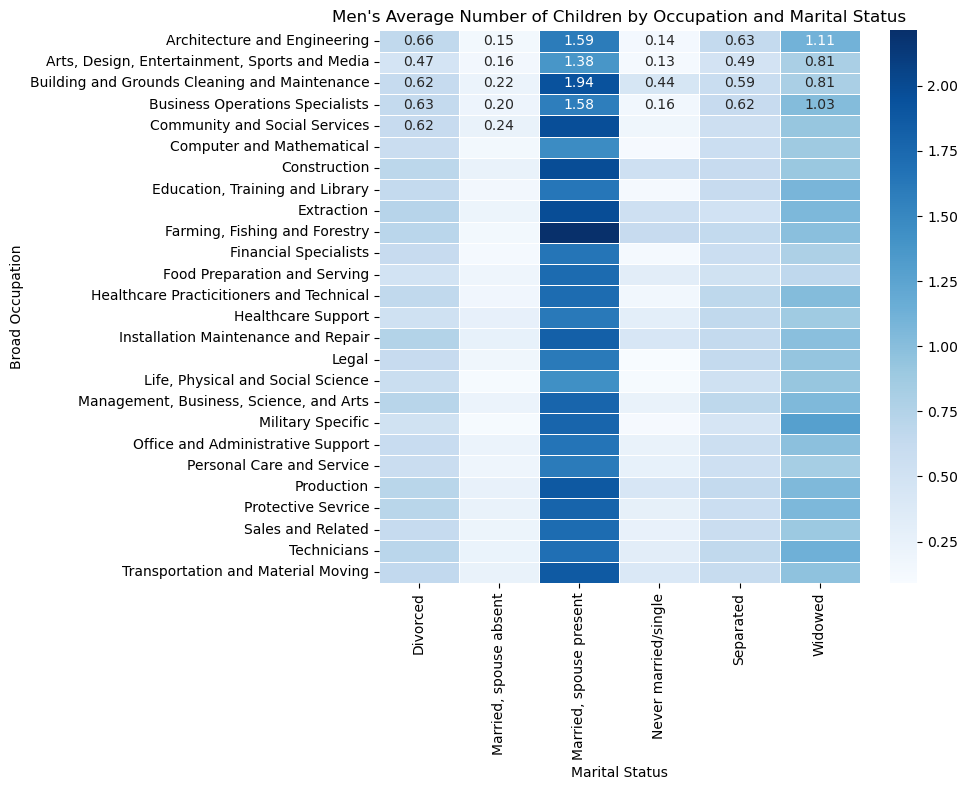

In [153]:
plt.figure(figsize=(10, 8))
sns.heatmap(broad_pivot, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

plt.title("Men's Average Number of Children by Occupation and Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Broad Occupation")
plt.tight_layout()
plt.savefig("results/occupations/heatmap_avg_children.png", dpi=300)
plt.show()

In [148]:
fathers_simple = fathers_filtered[fathers_filtered['MaritalGroup'].isin(['Married', 'Divorced', 'Single'])]


In [151]:
# Weighted average children by broad 0ccupation
grouped_simple = fathers_simple.groupby(['Broad_Occupation', 'MaritalGroup']).apply(
    lambda g: pd.Series({
        'avg_children': (g['NCHILD'] * g['PERWT']).sum() / g['PERWT'].sum(),
        'weighted_count': g['PERWT'].sum()
    })
).reset_index().sort_values('avg_children', ascending=False)


In [152]:
grouped_simple.head()

,Broad_Occupation,MaritalGroup,avg_children,weighted_count
14,Installation Maintenance and Repair,Divorced,0.751153,633261.0
8,Extraction,Divorced,0.721435,37887.0
17,"Management, Business, Science, and Arts",Divorced,0.718605,836109.0
22,Protective Sevrice,Divorced,0.710400,316416.0
21,Production,Divorced,0.704947,825811.0


In [ ]:
# Pivot the table: rows = occupations, columns = marital status, values = avg_children
simple_pivot = grouped_simple.pivot(index='Broad_Occupation', columns='MaritalGroup', values='avg_children')
simple_pivot = simple_pivot.fillna(0)  # Replace NaNs with 0


ValueError: Index contains duplicate entries, cannot reshape

MaritalStatus,Divorced,"Married, spouse absent","Married, spouse present",Never married/single,Separated,Widowed
Broad_Occupation,,,,,,
Architecture and Engineering,0.662475,0.145154,1.591881,0.136948,0.631113,1.113756
"Arts, Design, Entertainment, Sports and Media",0.467425,0.156795,1.382303,0.128074,0.486598,0.811077
Building and Grounds Cleaning and Maintenance,0.624168,0.217402,1.936826,0.442621,0.590598,0.812301
Business Operations Specialists,0.633003,0.201382,1.577787,0.158813,0.621136,1.025194
Community and Social Services,0.617824,0.242624,1.967477,0.180367,0.550774,0.925000


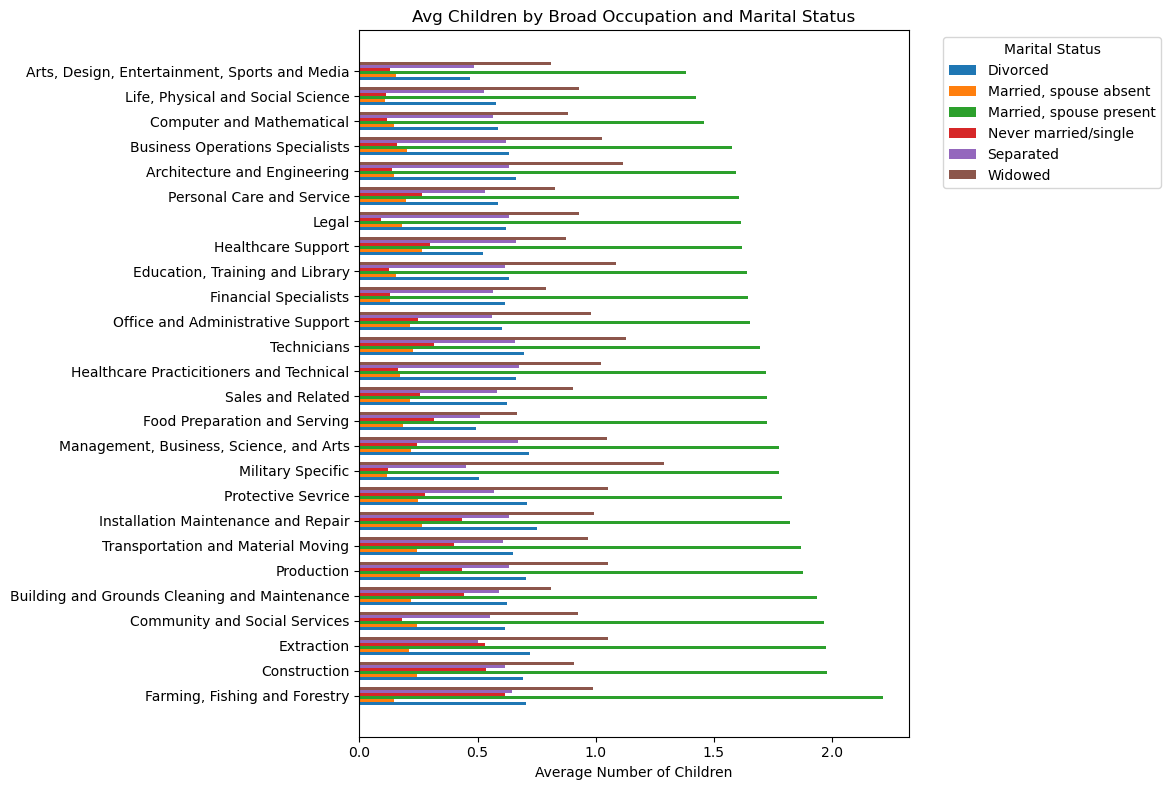

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step: Pivot the grouped data
simple_pivot = grouped_broad.pivot(index='Broad_Occupation', columns='MaritalGroup', values='avg_children').fillna(0)

# Sort rows by a reasonable status if present
sort_col = "Married"
if sort_col in simple_pivot.columns:
    simple_pivot = simple_pivot.sort_values(by=sort_col, ascending=False)
else:
    simple_pivot = simple_pivot.sort_values(by=simple_pivot.columns[0], ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
y = np.arange(len(simple_pivot.index))
n_statuses = len(simple_pivot.columns)
bar_width = 0.12
offsets = np.linspace(-bar_width * (n_statuses - 1) / 2, bar_width * (n_statuses - 1) / 2, n_statuses)

for i, col in enumerate(simple_pivot.columns):
    ax.barh(y + offsets[i], simple_pivot[col], height=bar_width, label=col)

ax.set_yticks(y)
ax.set_yticklabels(simple_pivot.index)
ax.set_xlabel("Average Number of Children")
ax.set_title("Avg Children by Broad Occupation and Marital Status")
ax.legend(title="Marital Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save to file
plt.savefig("results/occupations/grouped_avg_children_by_marital_status.png", dpi=300)
plt.show()
